In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier



import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping

import keras_tuner as kt



from keras.utils import to_categorical

from keras.layers import Input, Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.models import load_model

/Users/ville/repos/Ai-teori och tillämpning, del2/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Data

(10000, 784)
(10000,)
true lable for the plotted images is: 7


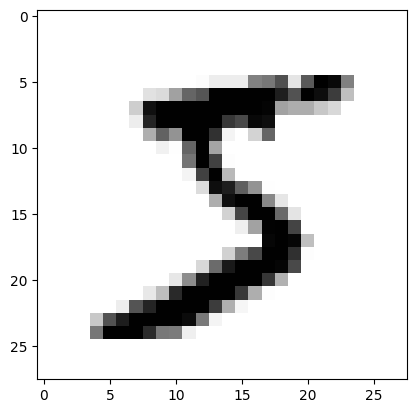

In [15]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X = mnist["data"][:10000]
Y = mnist["target"][:10000].astype(np.uint8)
print(X.shape)
print(Y.shape)


some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary)
print("true lable for the plotted images is:", Y[0])

# Data

In [ ]:
#tenserflow och keras
# Load the data (MNIST is built into Keras, which is faster than fetch_openml)
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [2]:

# Normalize pixels (from 0-255 to 0-1) - ANNs love small values!
X_train_full, X_test = X_train_full / 255.0, X_test / 255.0

# Extracting 5000 images from the training set to be used as a validation set.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## Model

In [3]:
#Step 2: build the ANN 

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), # Remake the 28x28 pictures into a long string of 784 pixels
    keras.layers.Dense(300, activation="relu"), 
    keras.layers.Dense(100, activation="relu"), 
    keras.layers.Dense(10, activation="softmax") 
])


/Users/ville/repos/Ai-teori och tillämpning, del2/.venv/lib/python3.13/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:

#step 3: compile and train the model 
model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

early_stopping_monitor = EarlyStopping(patience = 2)
trained_model_2 = model.fit(X_train, y_train, epochs=10, callbacks = [early_stopping_monitor])


Epoch 1/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9967 - loss: 0.0128 - val_accuracy: 0.9965 - val_loss: 0.0120
Epoch 2/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9977 - loss: 0.0092 - val_accuracy: 0.9962 - val_loss: 0.0159
Epoch 3/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9985 - loss: 0.0046 - val_accuracy: 0.9970 - val_loss: 0.0118
Epoch 4/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9980 - loss: 0.0073 - val_accuracy: 0.9898 - val_loss: 0.0474
Epoch 5/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9969 - loss: 0.0115 - val_accuracy: 0.9905 - val_loss: 0.0376


## KerasTuner model

In [5]:

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    
    # Tuner testing the Number of Neuron. between 32 and 512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    # Tuner Learning Rate Selection
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='my_dir',
    project_name='mnist_tuning'
)

early_stopping_monitor = EarlyStopping(patience=2)

# Start
tuner.search(X_train, y_train, 
             epochs=10, 
             validation_data=(X_valid, y_valid),
             callbacks=[early_stopping_monitor])

# Retrieve the Best Model and Evaluate
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test precision för den optimerade modellen: {test_acc}")

Reloading Tuner from my_dir/mnist_tuning/tuner0.json
  1/313 ━━━━━━━━━━━━━━━━━━━━ 38s 123ms/step - accuracy: 0.9688 - loss: 0.0495

/Users/ville/repos/Ai-teori och tillämpning, del2/.venv/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.9749 - loss: 0.0802
Test precision för den optimerade modellen: 0.9749000072479248
